In [1]:
from openai import OpenAI

from collections import Counter

from llmcoder.utils import get_openai_key, get_system_prompt

In [2]:
from bertopic import BERTopic
from tqdm import tqdm

/home/paulsaegert/anaconda3/envs/llmcoder/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
client = OpenAI(api_key=get_openai_key())

In [88]:
code = """# General imports
import os

import pandas as pd
import numpy as np
import spacy
import matplotlib
from wordcloud import WordCloud
from matplotlib import pyplot as plt

# Custom imports
from tqdm import tqdm
from collections import Counter

# Ensure matplotlib works correctly with Jupyter
%matplotlib inline

df_characters = pd.read_csv('data/simpsons_characters.csv').reset_index(inplace=False, drop=True)
df_locations = pd.read_csv('data/simpsons_locations.csv').reset_index(inplace=False, drop=True)
df_script = pd.read_csv('data/simpsons_script_lines.csv').reset_index(inplace=False, drop=True)
df_episodes = pd.read_csv('data/simpsons_episodes.csv').reset_index(inplace=False, drop=True)

# """

In [4]:
messages = [{
    "role": "system",
    "content": get_system_prompt(),
}, {
    "role": "user",
    "content": code
}]

In [5]:
N_SAMPLES = 1_000

In [6]:
assert N_SAMPLES <= 1000  # Otherwise this will get very expensive

chat_completions = []

pbar = tqdm(total=N_SAMPLES)
while len(chat_completions) < N_SAMPLES:
    chat_completion = client.chat.completions.create(messages=messages, model='ft:gpt-3.5-turbo-1106:personal::8LCi9Q0d', n=min(128, N_SAMPLES - len(chat_completions)))
    chat_completions.extend(chat_completion.choices)
    pbar.update(len(chat_completion.choices))

100%|██████████| 1000/1000 [00:27<00:00, 35.91it/s]

In [25]:
answer_list = [choice.message.content for choice in chat_completions]

len(answer_list)

1000

In [26]:
from sentence_transformers import SentenceTransformer
from umap import UMAP

In [27]:
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(answer_list, show_progress_bar=False)

In [33]:
from bertopic.representation import OpenAI

representation_model = OpenAI(client, model="gpt-3.5-turbo", delay_in_seconds=5, chat=True)

In [35]:
# Train BERTopic
topic_model = BERTopic(verbose=True, representation_model=representation_model).fit(answer_list, embeddings)

2023-12-07 21:25:05,044 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2023-12-07 21:25:11,571 - BERTopic - Dimensionality - Completed ✓
2023-12-07 21:25:11,573 - BERTopic - Cluster - Start clustering the reduced embeddings
2023-12-07 21:25:11,645 - BERTopic - Cluster - Completed ✓
2023-12-07 21:25:11,654 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 27/27 [02:45<00:00,  6.13s/it]
2023-12-07 21:27:57,536 - BERTopic - Representation - Completed ✓


In [ ]:
# Reduce dimensionality of embeddings, this step is optional but much faster to perform iteratively:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.3, metric='cosine').fit_transform(embeddings)

In [37]:
topic_representations = [topic_model.get_topic(topic_id) for topic_id in range(len(topic_model.get_topic_freq()))]

In [46]:
topic_model.set_topic_labels(topic_representations)

In [54]:
topic_model.visualize_documents(answer_list, reduced_embeddings=reduced_embeddings, width=1800, height=1000, hide_annotations=True, title="Next Thing After Importing Data:")

In [59]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("microsoft/CodeBERT-base")
model = AutoModelForSequenceClassification.from_pretrained("microsoft/CodeBERT-base")

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/CodeBERT-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [90]:
quality_scores = []
needs_comment_scores = []

for answer in tqdm(answer_list):
    full_code = code + answer

    # If the full_code is longer than 512 tokens, we need to truncate it
    while len(tokenizer.encode(full_code, return_tensors="pt")[0]) > 512:
        answer = answer[1:]
        full_code = code + answer

    input_ids = tokenizer.encode(full_code, return_tensors="pt")
    output = model(input_ids)
    quality_scores.append(output.logits[0, 0].tolist())
    needs_comment_scores.append(output.logits[0, 1].tolist())

quality_score_before = model(tokenizer.encode(code, return_tensors="pt")).logits[0, 0].tolist()
needs_comment_score_before = model(tokenizer.encode(code, return_tensors="pt")).logits[0, 1].tolist()

100%|██████████| 1000/1000 [12:51<00:00,  1.30it/s]


In [91]:
import matplotlib.pyplot as plt

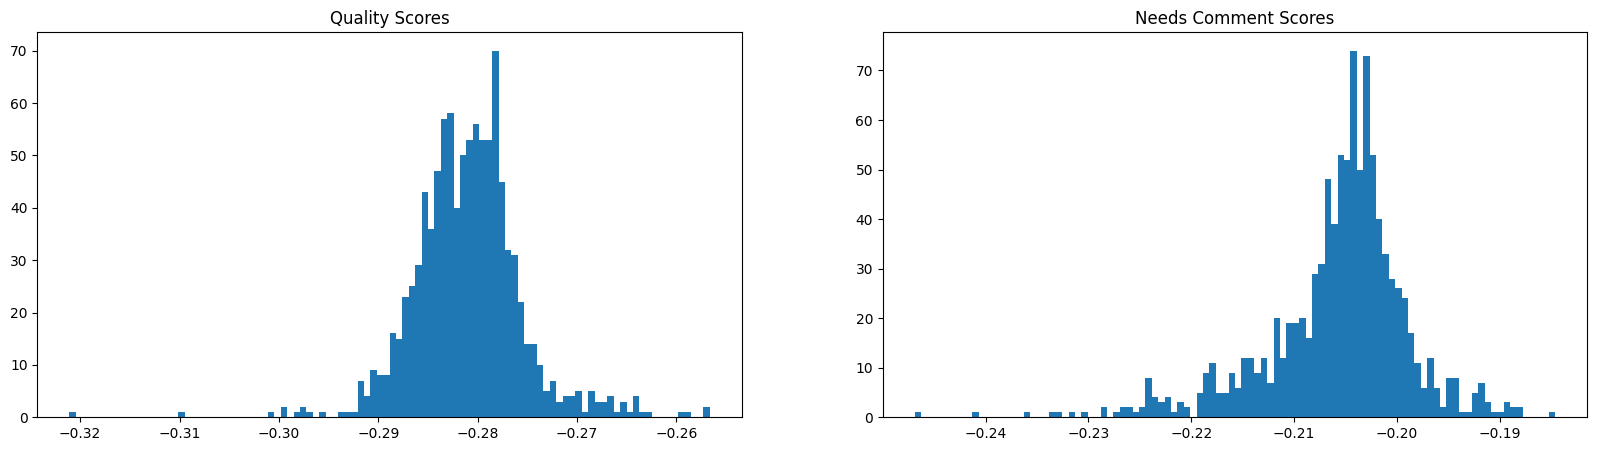

In [92]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].hist(quality_scores, bins=100)
ax[0].set_title("Quality Scores")
ax[1].hist(needs_comment_scores, bins=100)
ax[1].set_title("Needs Comment Scores");

In [93]:
# Show the best quality answers
best_quality_answers = sorted(zip(quality_scores, answer_list), reverse=True)
for quality, answer in best_quality_answers[:4]:
    print(f"Quality: {quality:.5f}\nAnswer: {answer}\n")

Quality: -0.25664
Answer: calculate the number of lines each character has spoken
lines_per_character = df_script['raw_character_text'].value_counts()

# Plot the distribution of number of lines spoken by each character
plt.figure(figsize=(10, 6))
plt.hist(lines_per_character, bins=range(50), edgecolor='black', log=True)
plt.xscale('log')
plt.yscale('log')
plt.title('Distribution of Number of Lines Spoken by Each Character')
plt.xlabel('Number of Lines Spoken')
plt.ylabel('Number of Characters')
plt.show()

Quality: -0.25674
Answer: Text cleaning
# Remove unused information
df_script = df_script.drop(['id','episode_id', 'number'], axis=1)

# Drop lines with missing values
df_script = df_script.dropna()

# Remove content in square brackets (often these are directions for the actor)
df_script = df_script.replace('\[.*?\]', '', regex=True)

# Special case (it's indeed lines that starts with space)
df_script['raw_character_text'] = df_script['raw_character_text'].replace('^[ \t]+', '', reg

In [94]:
# Show the worst quality answers
worst_quality_answers = sorted(zip(quality_scores, answer_list), reverse=False)
for quality, answer in worst_quality_answers[:4]:
    print(f"Quality: {quality:.5f}\nAnswer: {answer}\n")

Quality: -0.32108
Answer:  Merge script data with characters and locations
df_script = df_script[[
    'episode_id',
    'number',
    'raw_text',
    'timestamp_in_ms',
    'speaking_line',
    'character_id',
    'location_id',
    'raw_character_text',
    'raw_location_text',
    'spoken_words',
    'normalized_text',
]].merge(
    df_characters.add_prefix('character_'),
    left_on='character_id', 
    right_on='character_id', 
    suffixes=(None, '_dropped')
).merge(
    df_locations.add_prefix('location_'), 
    left_on='location_id', 
    right_on='location_id', 
    suffixes=(None, '_dropped')
)

# Merge with episodes data
df_script = df_script.merge(
    df_episodes.add_prefix('episode_'),
    left_on='episode_id',
    right_on='episode_id',
    suffixes=(None, '_dropped')
)

Quality: -0.30983
Answer: Merge the dataframes to create a single dataframe with all the information we need.
df = pd.merge(df_script,
              df_episodes,
              how='left',
              l